In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from sklearn import metrics

from keras.layers import Input

In [92]:
timestep = 256 #204
epoch = 200

## Load Input data

In [93]:
path = 'Nursing_csv_files_cleaned/mHealth'

sequences = list()
for i in range(11,57):
    file_path = path + str(i) + '.csv'
    file = pd.read_csv(file_path, header=0)
    file = file.drop(["event_time","id"], axis=1)
    #file = file.round(3)
    print(file.dtypes)
    sequences.append(file)

accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
rot1     float64
rot2     float64
rot3     float64
rot4     float64
rot5     float64
rot6     float64
rot7     float64
rot8     float64
rot9     float64
rotX     float64
rotY     float64
rotZ     float64
dtype: object
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
rot1     float64
rot2     float64
rot3     float64
rot4     float64
rot5     float64
rot6     float64
rot7     float64
rot8     float64
rot9     float64
rotX     float64
rotY     float64
rotZ     float64
dtype: object
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
rot1     float64
rot2     float64
rot3     float64
rot4     float64
rot5     float64
rot6     float64
rot7     float64
rot8     float64
rot9     float64
rotX     float64
rotY     float64
rotZ     float64
dtype: object
accX     float64
accY     float64
accZ  

## Load Output data

In [94]:
filePath = 'Nursing_csv_files_cleaned/master_list_mHealth.csv'
output = pd.read_csv(filePath, header=0)

output = output.drop(['age', 'education', 'gender', 'eth-race', 'weight (kg)', 'height (cm)', 'BMI'], axis=1)
output = output.drop(['depression', 'anxiety'], axis=1)
output.loc[output["mTBI_Y-N"]=="Y"]  = 1
output.loc[output["mTBI_Y-N"]=="N"]  = 0
print(output.head())

  mTBI_Y-N  mHealth
0        1        1
1        1        1
2        1        1
3        1        1
4        1        1


In [95]:
for i in range(0,len(sequences)):
    sequences[i] = sequences[i].rename(columns={'time': 'event_time'})

for i in range(0,len(sequences)):
    # if(sequences[i]["event_time"].dtype == "object"):
    #     sequences[i]['event_time'] = pd.to_datetime(sequences[i]['event_time'], format='%Y-%m-%d %H:%M:%S.%f')
    #     sequences[i]['event_time'] = sequences[i].event_time.values.astype(np.int64)
    #     sequences[i]['event_time'] = sequences[i]['event_time'].div(1000000)
    #     sequences[i]['event_time'] = sequences[i].event_time.values.astype(np.int64)
        
    # sequences[i]["event_time"] = sequences[i]['event_time'] - sequences[i]['event_time'][0]
        
    if 'id' in sequences[i].columns:
        sequences[i] = sequences[i].drop("id",axis=1)

    if 'rotX' in sequences[i].columns:
        sequences[i] = sequences[i].drop(["rotX","rotY","rotZ"],axis=1)


In [96]:
#for i in range (0,5000):
    #print(sequences[0]["event_time"][i])

X_file = list()
Y_file = list()

for data in range(0,len(sequences)):
    i = 0
    output_value = output[10+data:11+data]
    #print(output_value)
    
    # around 204 lines for 2000 miliseconds
    while i <= len(sequences[data])-timestep:
        # print(sequences[0]["event_time"][i:i+204])
        X_file.append(sequences[data][i:i+timestep])
        Y_file.append(output_value["mTBI_Y-N"].values[0])
        i=i+timestep

print(len(X_file))
print(len(Y_file))

4597
4597


In [97]:
X_file[0]

,accX,accY,accZ,gyroX,gyroY,gyroZ,rot1,rot2,rot3,rot4,rot5,rot6,rot7,rot8,rot9
0,9.32722,0.126816,-0.311066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.32962,0.325424,-0.229706,-0.071884,0.302979,0.030289,0.001276,-0.977809,-0.209497,-0.051856,0.209151,-0.976508,0.998654,0.012110,-0.050438
2,9.32962,0.325424,-0.229706,-0.071884,0.302979,0.030289,0.001276,-0.977809,-0.209497,-0.051856,0.209151,-0.976508,0.998654,0.012110,-0.050438
3,9.17886,0.440277,-0.215347,-0.059662,0.283432,0.035782,0.009222,-0.978292,-0.207028,-0.044915,0.206422,-0.977432,0.998948,0.018312,-0.042037
4,9.16930,0.449844,-0.234497,-0.046219,0.263885,0.037003,0.012763,-0.977460,-0.210736,-0.042593,0.210031,-0.976767,0.999011,0.021442,-0.038953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,10.82750,-0.423523,-1.926220,0.105255,0.190582,-0.261093,0.005939,-0.888332,0.459164,-0.001012,-0.459177,-0.888344,0.999982,0.004811,-0.003626
252,9.01137,-0.136398,-1.320830,-0.065765,0.296860,-0.636169,0.010045,-0.864037,0.503328,0.004455,-0.503310,-0.864095,0.999940,0.010923,-0.001206
253,8.16910,0.098099,-1.021730,-0.127472,0.337799,-0.736954,0.014537,-0.867534,0.497166,0.009965,-0.497068,-0.867654,0.999845,0.017567,0.001419
254,7.33640,0.339783,-0.672379,-0.176956,0.360397,-0.778503,0.017046,-0.869461,0.493708,0.013085,-0.493543,-0.869623,0.999769,0.021283,0.002964


In [98]:
base_model = load_model('models/best_model.pkl')


# old_model.add(LSTM(32, input_shape=(204, 16),dropout=0.1, name="lstm2"))


# print("weights:", len(layer.weights))
# print("trainable_weights:", len(layer.trainable_weights))
# print("non_trainable_weights:", len(layer.non_trainable_weights))


#for layer in model.layers:
#    layer.trainable = False

new_input = Input(shape=(timestep, 16),name="phone_data")
# extract all the layers from base model except the last layer

In [99]:
X_train, X_rest, Y_train, Y_rest = train_test_split(X_file, Y_file, test_size=0.5, random_state=0)
X_test, X_validation, Y_test, Y_validation  = train_test_split(X_rest, Y_rest, test_size=0.4, random_state=0)

print(len(X_train))
print(len(X_validation))
print(len(X_test))
print(len(X_train)+len(X_validation)+len(X_test))
print(len(X_file))

2298
920
1379
4597
4597


In [100]:
X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

Y_train = np.array(Y_train)

Y_validation = np.array(Y_validation)

Y_test = np.array(Y_test)


In [101]:
model = Sequential()
model.add(LSTM(256, input_shape=(timestep, 15),dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 256)               278528    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 278,785
Trainable params: 278,785
Non-trainable params: 0
_________________________________________________________________


In [102]:
adam = Adam(learning_rate=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=256, callbacks=[chk], validation_data=(X_validation,Y_validation))

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7463
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 36s 4s/step - loss: 0.5467 - accuracy: 0.7463 - val_loss: 0.5142 - val_accuracy: 0.7750
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7907
Epoch 2: val_accuracy did not improve from 0.77500
9/9 [==============================] - 25s 3s/step - loss: 0.4826 - accuracy: 0.7907 - val_loss: 0.5012 - val_accuracy: 0.7750
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.7889
Epoch 3: val_accuracy improved from 0.77500 to 0.77826, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 30s 3s/step - loss: 0.4643 - accuracy: 0.7889 - val_loss: 0.4839 - val_accuracy: 0.7783
Epoch 4/200
9/9 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.7959
Epoch 4: val_accuracy improved from 0.77826 to 0.78370, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 32s 4s/step - loss: 0.4506 - accuracy: 0.7959 - val_loss: 0.4660 - val_accuracy: 0.7837
Epoch 5/200
9/9 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.8168
Epoch 5: val_accuracy improved from 0.78370 to 0.80978, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 37s 4s/step - loss: 0.4330 - accuracy: 0.8168 - val_loss: 0.4414 - val_accuracy: 0.8098
Epoch 6/200
9/9 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8172
Epoch 6: val_accuracy did not improve from 0.80978
9/9 [==============================] - 28s 3s/step - loss: 0.4254 - accuracy: 0.8172 - val_loss: 0.4463 - val_accuracy: 0.8076
Epoch 7/200
9/9 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8468
Epoch 7: val_accuracy improved from 0.80978 to 0.83478, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 33s 4s/step - loss: 0.3884 - accuracy: 0.8468 - val_loss: 0.3992 - val_accuracy: 0.8348
Epoch 8/200
9/9 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8386
Epoch 8: val_accuracy improved from 0.83478 to 0.83696, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 32s 4s/step - loss: 0.3810 - accuracy: 0.8386 - val_loss: 0.4016 - val_accuracy: 0.8370
Epoch 9/200
9/9 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8681
Epoch 9: val_accuracy improved from 0.83696 to 0.84891, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 33s 4s/step - loss: 0.3430 - accuracy: 0.8681 - val_loss: 0.3856 - val_accuracy: 0.8489
Epoch 10/200
9/9 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8381
Epoch 10: val_accuracy did not improve from 0.84891
9/9 [==============================] - 40s 4s/step - loss: 0.3854 - accuracy: 0.8381 - val_loss: 0.4964 - val_accuracy: 0.7750
Epoch 11/200
9/9 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7907
Epoch 11: val_accuracy did not improve from 0.84891
9/9 [==============================] - 41s 5s/step - loss: 0.4718 - accuracy: 0.7907 - val_loss: 0.4633 - val_accuracy: 0.7750
Epoch 12/200
9/9 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.7981
Epoch 12: val_accuracy did not improve from 0.84891
9/9 [==============================] - 41s 5s/step - loss: 0.4195 - accuracy: 0.7981 - val_loss: 0.4191 - val_accuracy: 0.8141
Epoch 13/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 46s 5s/step - loss: 0.3461 - accuracy: 0.8547 - val_loss: 0.3307 - val_accuracy: 0.8587
Epoch 18/200
9/9 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8777
Epoch 18: val_accuracy improved from 0.85870 to 0.87283, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 46s 5s/step - loss: 0.2977 - accuracy: 0.8777 - val_loss: 0.3309 - val_accuracy: 0.8728
Epoch 19/200
9/9 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8738
Epoch 19: val_accuracy did not improve from 0.87283
9/9 [==============================] - 35s 4s/step - loss: 0.3112 - accuracy: 0.8738 - val_loss: 0.3490 - val_accuracy: 0.8511
Epoch 20/200
9/9 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8664
Epoch 20: val_accuracy did not improve from 0.87283
9/9 [==============================] - 34s 4s/step - loss: 0.3222 - accuracy: 0.8664 - val_loss: 0.3696 - val_accuracy: 0.8402
Epoch 21/200
9/9 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8760
Epoch 21: val_accuracy improved from 0.87283 to 0.88478, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 38s 4s/step - loss: 0.2928 - accuracy: 0.8760 - val_loss: 0.3005 - val_accuracy: 0.8848
Epoch 22/200
9/9 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8938
Epoch 22: val_accuracy did not improve from 0.88478
9/9 [==============================] - 35s 4s/step - loss: 0.2642 - accuracy: 0.8938 - val_loss: 0.3378 - val_accuracy: 0.8543
Epoch 23/200
9/9 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8446
Epoch 23: val_accuracy did not improve from 0.88478
9/9 [==============================] - 35s 4s/step - loss: 0.3523 - accuracy: 0.8446 - val_loss: 0.3721 - val_accuracy: 0.8304
Epoch 24/200
9/9 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8464
Epoch 24: val_accuracy did not improve from 0.88478
9/9 [==============================] - 35s 4s/step - loss: 0.3383 - accuracy: 0.8464 - val_loss: 0.3533 - val_accuracy: 0.8576
Epoch 25/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 40s 5s/step - loss: 0.2736 - accuracy: 0.8864 - val_loss: 0.3076 - val_accuracy: 0.8913
Epoch 29/200
9/9 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8547
Epoch 29: val_accuracy did not improve from 0.89130
9/9 [==============================] - 41s 5s/step - loss: 0.3240 - accuracy: 0.8547 - val_loss: 0.4667 - val_accuracy: 0.7783
Epoch 30/200
9/9 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8303
Epoch 30: val_accuracy did not improve from 0.89130
9/9 [==============================] - 42s 5s/step - loss: 0.3911 - accuracy: 0.8303 - val_loss: 0.4295 - val_accuracy: 0.7815
Epoch 31/200
9/9 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8351
Epoch 31: val_accuracy did not improve from 0.89130
9/9 [==============================] - 42s 5s/step - loss: 0.3654 - accuracy: 0.8351 - val_loss: 0.3697 - val_accuracy: 0.8413
Epoch 32/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 48s 6s/step - loss: 0.2182 - accuracy: 0.9204 - val_loss: 0.2493 - val_accuracy: 0.9196
Epoch 37/200
9/9 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9208
Epoch 37: val_accuracy did not improve from 0.91957
9/9 [==============================] - 48s 6s/step - loss: 0.2266 - accuracy: 0.9208 - val_loss: 0.5024 - val_accuracy: 0.8000
Epoch 38/200
9/9 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.8046
Epoch 38: val_accuracy did not improve from 0.91957
9/9 [==============================] - 42s 5s/step - loss: 0.4595 - accuracy: 0.8046 - val_loss: 0.3990 - val_accuracy: 0.8196
Epoch 39/200
9/9 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8381
Epoch 39: val_accuracy did not improve from 0.91957
9/9 [==============================] - 41s 5s/step - loss: 0.3703 - accuracy: 0.8381 - val_loss: 0.4166 - val_accuracy: 0.8217
Epoch 40/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 48s 5s/step - loss: 0.1608 - accuracy: 0.9386 - val_loss: 0.2209 - val_accuracy: 0.9228
Epoch 60/200
9/9 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9086
Epoch 60: val_accuracy did not improve from 0.92283
9/9 [==============================] - 44s 5s/step - loss: 0.2293 - accuracy: 0.9086 - val_loss: 0.3512 - val_accuracy: 0.8554
Epoch 61/200
9/9 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9169
Epoch 61: val_accuracy did not improve from 0.92283
9/9 [==============================] - 41s 5s/step - loss: 0.2269 - accuracy: 0.9169 - val_loss: 0.2320 - val_accuracy: 0.9076
Epoch 62/200
9/9 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9443
Epoch 62: val_accuracy did not improve from 0.92283
9/9 [==============================] - 41s 5s/step - loss: 0.1712 - accuracy: 0.9443 - val_loss: 0.2147 - val_accuracy: 0.9076
Epoch 63/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 46s 5s/step - loss: 0.1689 - accuracy: 0.9434 - val_loss: 0.1807 - val_accuracy: 0.9380
Epoch 66/200
9/9 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9456
Epoch 66: val_accuracy did not improve from 0.93804
9/9 [==============================] - 36s 4s/step - loss: 0.1541 - accuracy: 0.9456 - val_loss: 0.2015 - val_accuracy: 0.9348
Epoch 67/200
9/9 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9487
Epoch 67: val_accuracy did not improve from 0.93804
9/9 [==============================] - 35s 4s/step - loss: 0.1522 - accuracy: 0.9487 - val_loss: 0.1758 - val_accuracy: 0.9348
Epoch 68/200
9/9 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9569
Epoch 68: val_accuracy did not improve from 0.93804
9/9 [==============================] - 38s 4s/step - loss: 0.1361 - accuracy: 0.9569 - val_loss: 0.2242 - val_accuracy: 0.9272
Epoch 69/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 38s 4s/step - loss: 0.1103 - accuracy: 0.9652 - val_loss: 0.1657 - val_accuracy: 0.9402
Epoch 82/200
9/9 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9373
Epoch 82: val_accuracy did not improve from 0.94022
9/9 [==============================] - 37s 4s/step - loss: 0.1831 - accuracy: 0.9373 - val_loss: 0.1966 - val_accuracy: 0.9315
Epoch 83/200
9/9 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9143
Epoch 83: val_accuracy did not improve from 0.94022
9/9 [==============================] - 35s 4s/step - loss: 0.2517 - accuracy: 0.9143 - val_loss: 0.2653 - val_accuracy: 0.8837
Epoch 84/200
9/9 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9243
Epoch 84: val_accuracy did not improve from 0.94022
9/9 [==============================] - 36s 4s/step - loss: 0.1887 - accuracy: 0.9243 - val_loss: 0.2180 - val_accuracy: 0.9163
Epoch 85/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 43s 5s/step - loss: 0.1193 - accuracy: 0.9552 - val_loss: 0.1332 - val_accuracy: 0.9446
Epoch 91/200
9/9 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9652
Epoch 91: val_accuracy improved from 0.94457 to 0.96087, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 53s 6s/step - loss: 0.0922 - accuracy: 0.9652 - val_loss: 0.1216 - val_accuracy: 0.9609
Epoch 92/200
9/9 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9682
Epoch 92: val_accuracy did not improve from 0.96087
9/9 [==============================] - 48s 5s/step - loss: 0.0786 - accuracy: 0.9682 - val_loss: 0.1246 - val_accuracy: 0.9511
Epoch 93/200
9/9 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9704
Epoch 93: val_accuracy did not improve from 0.96087
9/9 [==============================] - 48s 5s/step - loss: 0.0721 - accuracy: 0.9704 - val_loss: 0.1172 - val_accuracy: 0.9489
Epoch 94/200
9/9 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9643
Epoch 94: val_accuracy improved from 0.96087 to 0.96196, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 53s 6s/step - loss: 0.0869 - accuracy: 0.9643 - val_loss: 0.0897 - val_accuracy: 0.9620
Epoch 95/200
9/9 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9748
Epoch 95: val_accuracy improved from 0.96196 to 0.96848, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 46s 5s/step - loss: 0.0645 - accuracy: 0.9748 - val_loss: 0.0827 - val_accuracy: 0.9685
Epoch 96/200
9/9 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9822
Epoch 96: val_accuracy did not improve from 0.96848
9/9 [==============================] - 36s 4s/step - loss: 0.0532 - accuracy: 0.9822 - val_loss: 0.1209 - val_accuracy: 0.9587
Epoch 97/200
9/9 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9413
Epoch 97: val_accuracy did not improve from 0.96848
9/9 [==============================] - 37s 4s/step - loss: 0.1781 - accuracy: 0.9413 - val_loss: 0.1809 - val_accuracy: 0.9250
Epoch 98/200
9/9 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9330
Epoch 98: val_accuracy did not improve from 0.96848
9/9 [==============================] - 36s 4s/step - loss: 0.1424 - accuracy: 0.9330 - val_loss: 0.1436 - val_accuracy: 0.9304
Epoch 99/200
9/9 [==============================] - ET

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 48s 6s/step - loss: 0.0540 - accuracy: 0.9830 - val_loss: 0.0861 - val_accuracy: 0.9717
Epoch 106/200
9/9 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9691
Epoch 106: val_accuracy did not improve from 0.97174
9/9 [==============================] - 46s 5s/step - loss: 0.0951 - accuracy: 0.9691 - val_loss: 0.1992 - val_accuracy: 0.9207
Epoch 107/200
9/9 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9408
Epoch 107: val_accuracy did not improve from 0.97174
9/9 [==============================] - 45s 5s/step - loss: 0.1465 - accuracy: 0.9408 - val_loss: 0.1444 - val_accuracy: 0.9467
Epoch 108/200
9/9 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9695
Epoch 108: val_accuracy did not improve from 0.97174
9/9 [==============================] - 46s 5s/step - loss: 0.0948 - accuracy: 0.9695 - val_loss: 0.1371 - val_accuracy: 0.9533
Epoch 109/200
9/9 [=============================

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 51s 6s/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.0824 - val_accuracy: 0.9761
Epoch 113/200
9/9 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9839
Epoch 113: val_accuracy improved from 0.97609 to 0.97826, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 52s 6s/step - loss: 0.0468 - accuracy: 0.9839 - val_loss: 0.0750 - val_accuracy: 0.9783
Epoch 114/200
9/9 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9887
Epoch 114: val_accuracy improved from 0.97826 to 0.98152, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 50s 6s/step - loss: 0.0387 - accuracy: 0.9887 - val_loss: 0.0806 - val_accuracy: 0.9815
Epoch 115/200
9/9 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9878
Epoch 115: val_accuracy did not improve from 0.98152
9/9 [==============================] - 39s 4s/step - loss: 0.0416 - accuracy: 0.9878 - val_loss: 0.0779 - val_accuracy: 0.9793
Epoch 116/200
9/9 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9904
Epoch 116: val_accuracy improved from 0.98152 to 0.98261, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 45s 5s/step - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.0638 - val_accuracy: 0.9826
Epoch 117/200
9/9 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9900
Epoch 117: val_accuracy improved from 0.98261 to 0.98370, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 43s 5s/step - loss: 0.0293 - accuracy: 0.9900 - val_loss: 0.0587 - val_accuracy: 0.9837
Epoch 118/200
9/9 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9878
Epoch 118: val_accuracy did not improve from 0.98370
9/9 [==============================] - 48s 5s/step - loss: 0.0330 - accuracy: 0.9878 - val_loss: 0.0804 - val_accuracy: 0.9750
Epoch 119/200
9/9 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9804
Epoch 119: val_accuracy did not improve from 0.98370
9/9 [==============================] - 47s 5s/step - loss: 0.0559 - accuracy: 0.9804 - val_loss: 0.1169 - val_accuracy: 0.9587
Epoch 120/200
9/9 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9704
Epoch 120: val_accuracy did not improve from 0.98370
9/9 [==============================] - 48s 5s/step - loss: 0.0763 - accuracy: 0.9704 - val_loss: 0.1190 - val_accuracy: 0.9511
Epoch 121/200
9/9 [=============================

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 52s 6s/step - loss: 0.0381 - accuracy: 0.9865 - val_loss: 0.0392 - val_accuracy: 0.9880
Epoch 125/200
9/9 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9922
Epoch 125: val_accuracy did not improve from 0.98804
9/9 [==============================] - 49s 6s/step - loss: 0.0282 - accuracy: 0.9922 - val_loss: 0.1045 - val_accuracy: 0.9750
Epoch 126/200
9/9 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9835
Epoch 126: val_accuracy did not improve from 0.98804
9/9 [==============================] - 47s 5s/step - loss: 0.0531 - accuracy: 0.9835 - val_loss: 0.1090 - val_accuracy: 0.9609
Epoch 127/200
9/9 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9735
Epoch 127: val_accuracy did not improve from 0.98804
9/9 [==============================] - 46s 5s/step - loss: 0.0695 - accuracy: 0.9735 - val_loss: 0.0754 - val_accuracy: 0.9761
Epoch 128/200
9/9 [=============================

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 112s 13s/step - loss: 0.0333 - accuracy: 0.9909 - val_loss: 0.0377 - val_accuracy: 0.9902
Epoch 139/200
9/9 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9769 
Epoch 139: val_accuracy did not improve from 0.99022
9/9 [==============================] - 102s 11s/step - loss: 0.0574 - accuracy: 0.9769 - val_loss: 0.1031 - val_accuracy: 0.9630
Epoch 140/200
9/9 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9861
Epoch 140: val_accuracy did not improve from 0.99022
9/9 [==============================] - 102s 11s/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 0.1747 - val_accuracy: 0.9500
Epoch 141/200
9/9 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9617
Epoch 141: val_accuracy did not improve from 0.99022
9/9 [==============================] - 99s 11s/step - loss: 0.1198 - accuracy: 0.9617 - val_loss: 0.0831 - val_accuracy: 0.9717
Epoch 142/200
9/9 [=====================

INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


9/9 [==============================] - 106s 12s/step - loss: 0.0220 - accuracy: 0.9952 - val_loss: 0.0407 - val_accuracy: 0.9913
Epoch 145/200
9/9 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9930
Epoch 145: val_accuracy did not improve from 0.99130
9/9 [==============================] - 76s 8s/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0441 - val_accuracy: 0.9913
Epoch 146/200
9/9 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9943
Epoch 146: val_accuracy did not improve from 0.99130
9/9 [==============================] - 74s 8s/step - loss: 0.0205 - accuracy: 0.9943 - val_loss: 0.1095 - val_accuracy: 0.9772
Epoch 147/200
9/9 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9917
Epoch 147: val_accuracy did not improve from 0.99130
9/9 [==============================] - 74s 8s/step - loss: 0.0338 - accuracy: 0.9917 - val_loss: 0.0928 - val_accuracy: 0.9837
Epoch 148/200
9/9 [===========================

In [103]:

# model = Sequential()
# model.add(new_input)
# model.summary()
# model.add(base_model.layers[0])

#for layer in base_model.layers[:1]:
# model.add(layer)
 
# Freeze all the layers of base model
#for layer in model.layers:
# layer.trainable=False

#base_model.summary()
# adding new layers

# for layer in base_model.layers[:1]:
# model.add(layer)
 
# Freeze all the layers of base model
# for layer in model.layers:
# layer.trainable=False

# base_model.summary()
# adding new layers

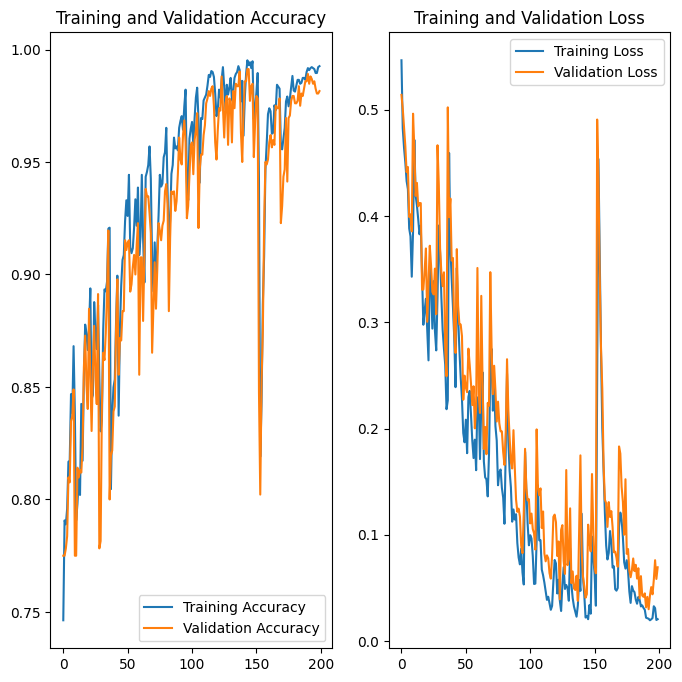

In [105]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()